<a href="https://colab.research.google.com/github/ArianAmani/Mask-Detection/blob/main/Mask_Detection(YoloV4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask Detection using Yolov4
![picture](https://drive.google.com/uc?id=1U0LwtIafuGFC7eOfP83esCk1yGQTgMB-)

In [ ]:
# Mount drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# This creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive

#Navigate to /mydrive/yolov4
%cd /mydrive/AI-Projects/Mask-Detection/yolov4

In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import glob
import cv2

In [ ]:
# Clone the darknet repository
# Darknet is an open source neural network framework
!git clone https://github.com/AlexeyAB/darknet

# Downloading our dataset from Kaggle.com
You can use any dataset you want.
I'm using [Face Mask Detection](https://www.kaggle.com/andrewmvd/face-mask-detection).

To download from Kaggle to Colab, you need to do the following steps:

In [ ]:
# Get your kaggle.json file from your Kaggle account
# Upload your kaggle.json file
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download your dataset from Kaggle
%cd ..
!kaggle datasets download -d andrewmvd/face-mask-detection

In [ ]:
! unzip face-mask-detection.zip -d dataset/

In [ ]:
# Copy all the images into yolov4/obj
! mkdir yolov4/obj
! cp dataset/images/* yolov4/obj

# Preparing the data
This data is in Pascal VOC format(XML).
To use it with Yolo and the Darknet framework, we need to convert the data to the Yolo format.

(If you are already using a Yolo format dataset, skip this part)

In [ ]:
# Code from https://www.kaggle.com/eugeniogrant/covid19-mask-detection-with-yolov5

classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_png_file_name, size, img_box):
    save_file_name = 'yolov4/obj' + '/' + img_png_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0])

        new_box = cord_converter(size, box[1:])

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_png_file_name = img_xml_file + '.png'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)

    # test_dataset_box_feature(img_png_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
files = os.listdir('dataset/annotations')
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data('dataset/annotations', file_xml[0])

Now we have all the data(both the pictures and the txt files) in 'yolov4/obj'

Now it's time to create the files we need for Darknet

# Create your config file
You can download the [yolov4-custom.cfg](https://github.com/AlexeyAB/darknet/blob/master/cfg/yolov4-custom.cfg) from the [Darknet repository](https://github.com/AlexeyAB/darknet/tree/master/cfg). You can also access it from the darknet repo you cloned.(darknet/cfg)

# Make changes to it


*   change the batch to batch=64
*   change the subdivisions to subdivisions=16 (if you're using Colab, you might want to change this to 32 to avoid problems with the memory)
*   change width and height to a value multiple of 32(I used 416)
*   change line max_batches to (classes*2000, but not less than number of training images and not less than 6000), f.e. max_batches=6000 if you train for 3 classes (Although this depends on the size of your dataset too, the dataset I used is not so big so I stopped training after about 4000 iterations)
*   change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
*   change line classes=80 to your number of objects in each of 3 [yolo]-layers
*   change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers. We have 3 classes so it will be filters=24

You can change the config as you wish if you know what you're doing.

# Create your obj.data and obj.names files
obj.data contains:


*   #Classes
*   Path to train.txt and test.txt files
*   Path to obj.names file
*   Path to the backup directory to save the weights


```
classes = 3
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = ../training
```

obj.names contains your objects names:
```
with_mask
without_mask
mask_weared_incorrect
```


# Create train.txt and test.txt
These two files contain paths to our images in the following format:

```
data/obj/maksssksksss108.png
data/obj/maksssksksss117.png
data/obj/maksssksksss126.png
data/obj/maksssksksss135.png
.
.
.
```
You can use this [script](https://github.com/techzizou/yolov4-custom_Training/blob/main/yolov4/process.py) from [techzizou's GitHub](https://github.com/techzizou/yolov4-custom_Training). (For this dataset, you need to change the .jpg format to .png in the script)


# Make these changes to the Makefile and run make to compile Darknet with GPU

In [ ]:
%cd darknet/
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [ ]:
!make

# Now it's time to copy your files into the darknet directory

* Copy `yolov4-custom.cfg` to `darknet/cfg`
* Copy `obj.data` and `obj.names` to `darknet/data`
* Copy your dataset to `darkent/data/obj`
* Copy the script mentioned above to `darknet`

In [ ]:
%cd ..
!cp yolov4-custom.cfg darknet/cfg
!cp obj.names darknet/data
!cp obj.data  darknet/data
!cp obj/* darknet/data/obj
!cp process.py darknet

# Create your train.txt and test.txt files using `process.py`

In [ ]:
!python process.py

/content/gdrive/MyDrive/AI-Projects/Mask-Detection/yolov4/darknet


# Download the pre-trained weights to avoid training from scratch

We use transfer learning and download the [pre-trained weights](https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137) to get the best results

In [ ]:
# Transfer Learning
# Download pre-trained weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

# Now we train on our dataset
* Use the -map flag to train with mAP (mean average precision) calculations. The higher the mAP is, the better.
This indicator is better than Loss, so train while mAP increases.

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg yolov4.conv.137 -dont_show -map

# If your session got interrupted, you can start training from where you left off:
Every 100 iterations, your weights are saved in the `yolov4/training` directory(backup in obj.data) as `yolov4-custom_last.weights`
So just start training again using

`!./darknet detector train data/obj.data cfg/yolov4-custom.cfg ../training/yolov4-custom_last.weights -dont_show -map`

**You will have to run the first cell and make changes to the Makefile and run the make command again if your colab session gets disconnected**

# You can see your progress by checking the `chart.png` file

In [ ]:
# Function to show pictures easily
def showImage(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (3*img.shape[1], 3*img.shape[0]))
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.axis('off')
    ax.imshow(img)

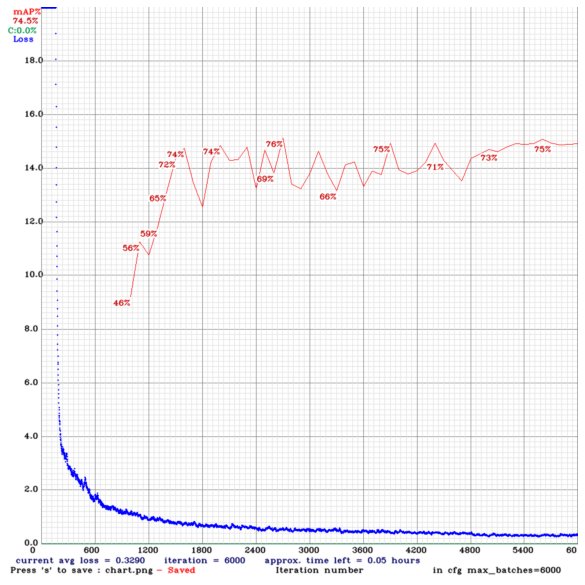

In [ ]:
showImage('chart.png')
# P.S. This is my training progress chart for yolov4-tiny model

# After the training is done, we can test our project
In the config file, change batch to `batch=1` and subdivisions to `subdivisions=1` to enter test-mode

# Test a picture using the command below

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

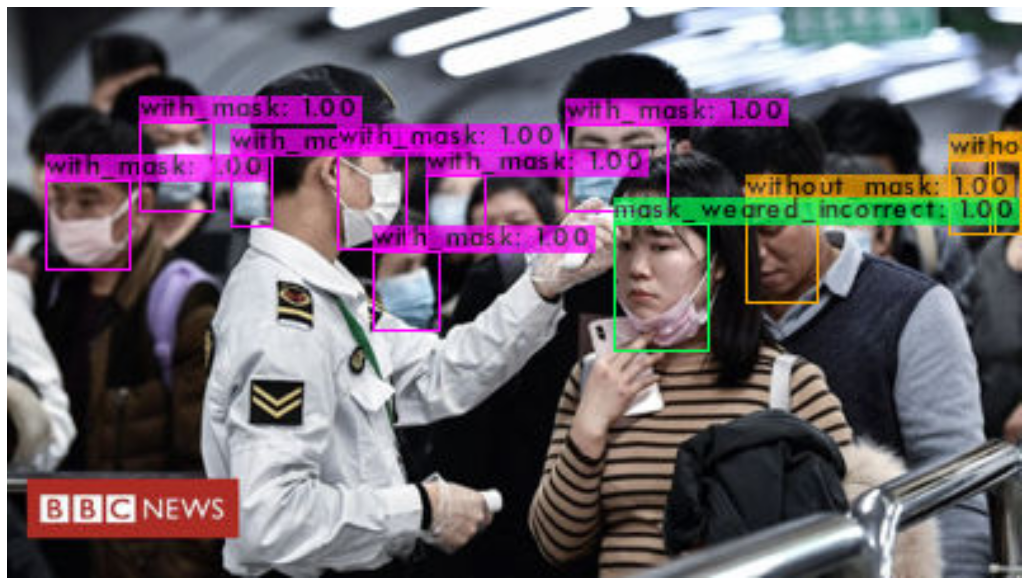

In [ ]:
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg ../training/yolov4-custom_best.weights data/obj/maksssksksss176.png -thresh 0.3
showImage('predictions.jpg')

# Run it on a video using the cell below

![picture](https://drive.google.com/uc?id=1YQR8h-9OtL8G_fzejUaWLjT1WtIzwKTs)

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov4-custom.cfg ../training/yolov4-custom_best.weights -dont_show video1.mp4 -thresh 0.3 -i 0 -out_filename results1.avi

# You can run it live on your webcam from Colab using the code below

**Change the line where you load your files to your own paths(line 21)**

![picture](https://drive.google.com/uc?id=1bNfyRnk17zj3OoZYSx87geIPXoWMlIGz)



In [ ]:
# Code from https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/blob/master/yolov4_webcam.ipynb

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline


# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4-custom.cfg", "data/obj.data", "../training/yolov4-custom_best.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes  

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# Read Darknet's documentation for more information
**https://github.com/AlexeyAB/darknet/**